In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
from IPython.display import clear_output



env = gym.make('Taxi-v3')
print(env.action_space)
print(env.observation_space)
n_states, n_actions = env.observation_space.n, env.action_space.n

env.render()

Discrete(6)
Discrete(500)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
def TD_0(strategie, alpha, gamma, iterations=1000, V=None,plot=False):
    if V == None:
        V = [(0)] * n_states
    for i_episode in range(iterations):
        S = env.reset()
        for t in range(1000):
            action = np.random.choice(np.arange(0, n_actions), p=strategie[S]) 
            S_prime, reward, done, info = env.step(action)
            V[S] += alpha * (reward + gamma * V[S_prime] - V[S])
             
            S = S_prime
            if done:
                break
    return V

# Strategie equiprobable : affichage de la valeur de la stratégie quand le passager est déja dans le taxi et qu'il se dirige au point B

In [3]:
def plot_V_S(V):
    list_states = []
    for i in range(5):
        for j in range(5):
            list_states.append(env.encode(i, j, 4, 3))

    s = []
    for i in list_states:
        s.append(V[i])

    s = np.asarray(s).reshape(5,5)
    heatmap = plt.imshow(s, interpolation='nearest')
    plt.colorbar(heatmap)
    plt.show()

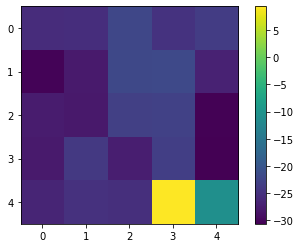

In [4]:
strategie = [[1/n_actions] * n_actions] * n_states
#V = TD_0(strategie, 0.5, 0.9, True)
V = None
for i in range(100):
    clear_output(wait=True)
    V = TD_0(strategie, 0.5, 0.9, 10, V)
    plot_V_S(V)

In [5]:
def epsilon_greedy(Q, epsilon, n_actions, S):
    A = np.ones(n_actions, dtype=float) * epsilon / n_actions
    best_action = np.argmax(Q[S])
    A[best_action] += (1.0 - epsilon)
    #print(A)
    return np.random.choice(np.arange(len(A)), p=A)

In [6]:
import time

def test_agent(Q):
    done = False
    S = env.reset()
    total = 0

    while not done:
        A = np.argmax(Q[S])
        S, reward, done, _ = env.step(A)
        total += reward
        time.sleep(0.5)
        clear_output(wait=True)
        env.render()
        print("Gain:", total)

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [8]:
def print_stats(rew):
    fig = plt.figure(figsize=(20, 5))
    ax1 = plt.subplot(121)
    ax1.title.set_text("Récompenses par épisode")
    plt.plot(rew, linewidth=1)
    ax2 = plt.subplot(122)
    ax2.title.set_text("Moyenne mobile (10 épisodes)")
    plt.plot(running_mean(rew, 10), linewidth=1)
    plt.show()

Récompense maximale: 15


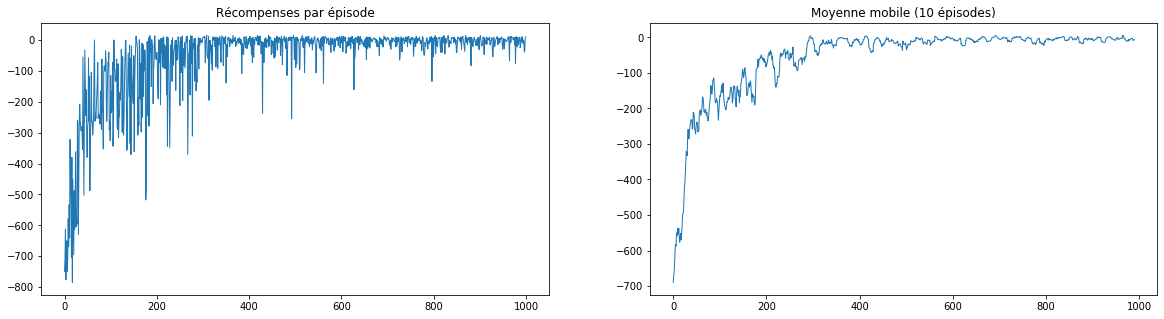

In [9]:
def SARSA(epsilon, alpha, gamma):
    rew = []
    Q = np.zeros((n_states, n_actions))
    for i_episode in range(1000):
        total_reward = 0
        S = env.reset()
        A = epsilon_greedy(Q, epsilon, n_actions, S)
        for t in range(20000):
            S_prime, reward, done, info = env.step(A)
            total_reward += reward
            
            A_prime = epsilon_greedy(Q, epsilon, n_actions, S_prime)
            
            if done and t != 200:
                Q[S][A] += alpha * (reward - Q[S][A])
            
            else:
                Q[S][A] += alpha * (reward + gamma * Q[S_prime][A_prime] - Q[S][A])
            
            S = S_prime
            A = A_prime
            
            if done:
                rew.append(total_reward)
                break

    print("Récompense maximale:", np.max(rew))
    print_stats(rew)
    return Q

Q_S = SARSA(0.1, 0.5, 1)

In [10]:
test_agent(Q_S)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Gain: 4


Récompense maximale: 15


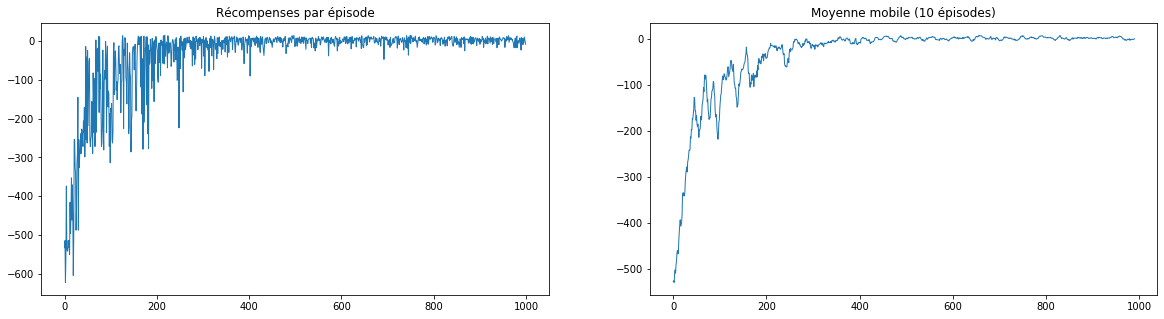

In [11]:
def Q_learning(epsilon, alpha, gamma):
    rew = []
    Q = np.zeros((n_states, n_actions))
    for i_episode in range(1000):
        total_reward = 0
        S = env.reset()
        for t in range(20000):
            A = epsilon_greedy(Q, epsilon, n_actions, S)
            #A = env.action_space.sample()
            S_prime, reward, done, info = env.step(A)
            total_reward += reward
            
            if done and t != 200:
                Q[S][A] += alpha * (reward - Q[S][A])
            else:
                Q[S][A] += alpha * (reward + gamma * np.max(Q[S_prime]) - Q[S][A])
            S = S_prime
            
            if done:
                rew.append(total_reward)
                break
    print("Récompense maximale:", np.max(rew))
    print_stats(rew)
    return Q

Q_Q = Q_learning(0.1, 0.5, 0.9)

In [12]:
test_agent(Q_Q)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Gain: 3


# On policy vs off policy

Récompense maximale: -57


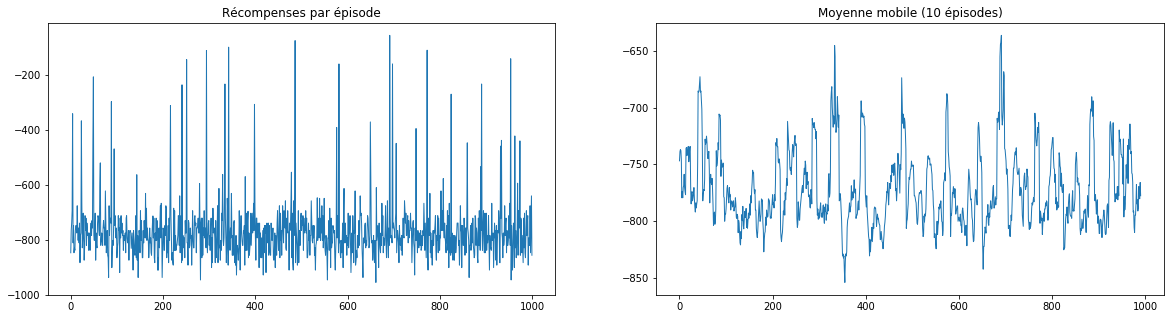

In [13]:
Q_Q_rand = Q_learning(1, 0.5, 0.9)

Récompense maximale: -17


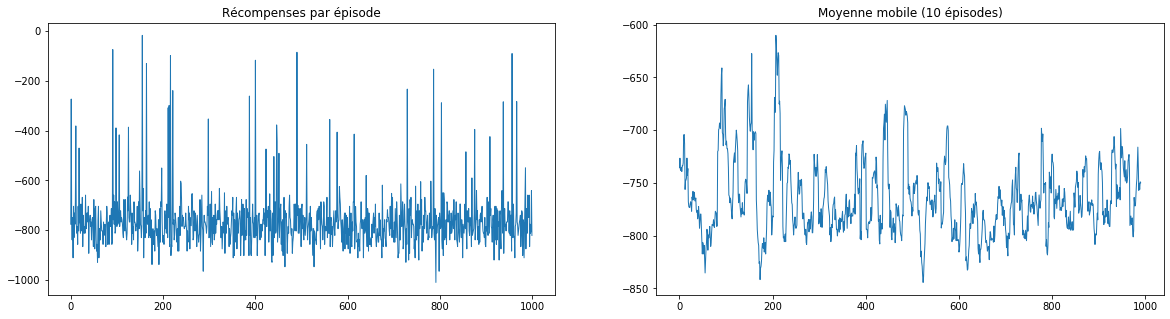

In [14]:
Q_S_rand = SARSA(1, 0.5, 0.9)

In [13]:
test_agent(Q_S_rand)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Gain: -13


KeyboardInterrupt: 

In [15]:
test_agent(Q_Q_rand)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Gain: 8


# Retour sur TD(0)

In [16]:
def Q_to_strategie(Q):
    l_indices = np.argmax(Q, axis=1).tolist()
    strategie = []
    for indice in l_indices:
        action = [(0)] * n_actions
        action[indice] = 1
        strategie.append(action)
    return strategie

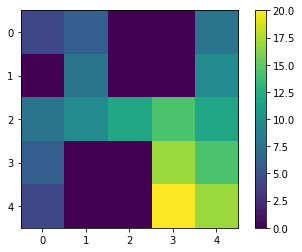

In [18]:
strategie = Q_to_strategie(Q_Q)
V = None
for i in range(150):
    clear_output(wait=True)
    V = TD_0(strategie, 0.5, 0.9, 10, V)
    plot_V_S(V)

In [39]:
print(list(env.decode(475)))

[4, 3, 3, 3]


encodage : (taxi_row, taxi_col, passenger_location, destination)

 Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
        
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    Rewards: 
    There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations


In [ ]:
def visualise_valeur_strategie(V, Q):
    done = False
    S = env.reset()
    total = 0

    while not done:
        A = np.argmax(Q[S])
        S, reward, done, _ = env.step(A)
        total += reward
        time.sleep(0.5)
        clear_output(wait=True)
        print(S)
        env.render()
        print("Valeur de l'état:", V[S])
        print("Gain:", total)